In [7]:
import io

import cv2
import numpy as np
import torch
import uvicorn
from fastapi import FastAPI, File, UploadFile
from fastapi.responses import StreamingResponse
from PIL import Image
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
import matplotlib.pyplot as plt


In [2]:
app = FastAPI()
# DeepLabV3 + ResNet50（COCOデータセットで学習済み）を読み込み 推論モードに設定
model = deeplabv3_resnet50(pretrained=True).eval()
# 画像前処理パイプライン
transform = transforms.Compose([
    transforms.Resize((480, 640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

c:\Users\kida0\dev\server\app\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kida0\dev\server\app\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# フォームデータとして画像ファイル(UploadFile)を受け取る
@app.post("/api/detect")
async def detect(file: UploadFile = File(...)):
    img = Image.open(file.file).convert("RGB")
    input_tensor = transform(img).unsqueeze(0)

    with torch.no_grad():
        output = model(input_tensor)['out'][0]
        preds = output.argmax(0).byte().cpu().numpy()

    mask = (preds == 15).astype(np.uint8) * 255
    np_img = np.array(img)
    overlay = np_img.copy()
    overlay[mask == 255] = [0, 0, 255]
    blended = cv2.addWeighted(np_img, 0.6, overlay, 0.4, 0)

    _, jpeg = cv2.imencode(".jpg", blended)
    return StreamingResponse(io.BytesIO(jpeg.tobytes()), media_type="image/jpeg")


### 前処理

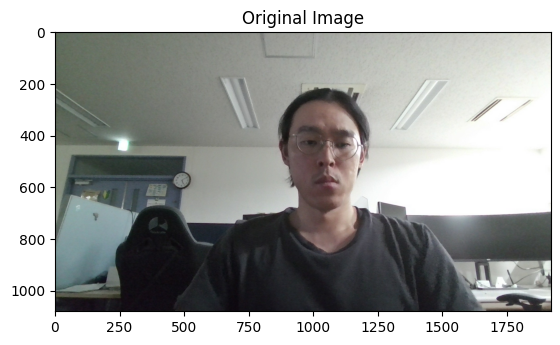

In [ ]:
# 画像ファイルの読み込み
img_path = "test.jpg"  
img = Image.open(img_path).convert("RGB")
plt.imshow(img)
plt.title("Original Image")
plt.show()

In [11]:
# 3. 前処理を適用
input_tensor = transform(img).unsqueeze(0)  # (1, C, H, W)
# 4. 推論
with torch.no_grad():
    output = model(input_tensor)['out'][0]  # (num_classes, H, W)
    preds = output.argmax(0).byte().cpu().numpy()  # 各ピクセルのクラスID

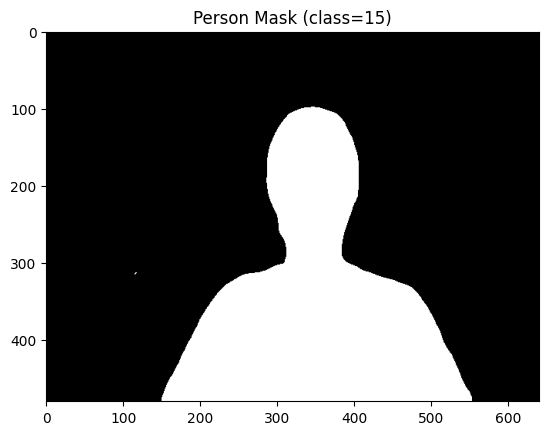

IndexError: boolean index did not match indexed array along axis 0; size of axis is 1080 but size of corresponding boolean axis is 480

In [12]:
# 5. マスク生成（クラス15=person）
mask = (preds == 15).astype(np.uint8) * 255
plt.imshow(mask, cmap="gray")
plt.title("Person Mask (class=15)")
plt.show()

# 6. 元画像にオーバーレイ
np_img = np.array(img)
overlay = np_img.copy()
overlay[mask == 255] = [0, 0, 255]  # 赤塗り
plt.imshow(overlay)
plt.title("Overlay (Red on Person)")
plt.show()

# 7. ブレンド合成
blended = cv2.addWeighted(np_img, 0.6, overlay, 0.4, 0)
plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
plt.title("Blended Image")
plt.show()

# 8. JPEGエンコードして保存（StreamingResponseの代わりに保存）
_, jpeg = cv2.imencode(".jpg", blended)
with open("result.jpg", "wb") as f:
    f.write(jpeg.tobytes())

print("処理完了: result.jpg に結果画像を保存しました。")

### 起動

In [5]:
# if __name__ == "__main__":
    # uvicorn server_node:app --host 0.0.0.0 --port 8080
uvicorn.run(app, host="0.0.0.0", port=8000)

RuntimeError: asyncio.run() cannot be called from a running event loop